# Using LASSO Regression for Feature Selection

Beginners level Machine Learning (ML) project. The aim here is to predict a students final score (G3) based on a number of factors. This will be a regression based ML project using sklearn.

The idea in this is to use a LASSO regression analysis. LASSO allows the model to normalise the factors, and shrink the factors that are not important to 0. This is important in a professional sense as it allows us to easily identify what effects the predicted value.

In [29]:
# Handle all the imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [30]:
# Import the data and inspect it

maths = pd.read_csv(r'./student-mat.csv', sep=';')
print(maths.info())
maths.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


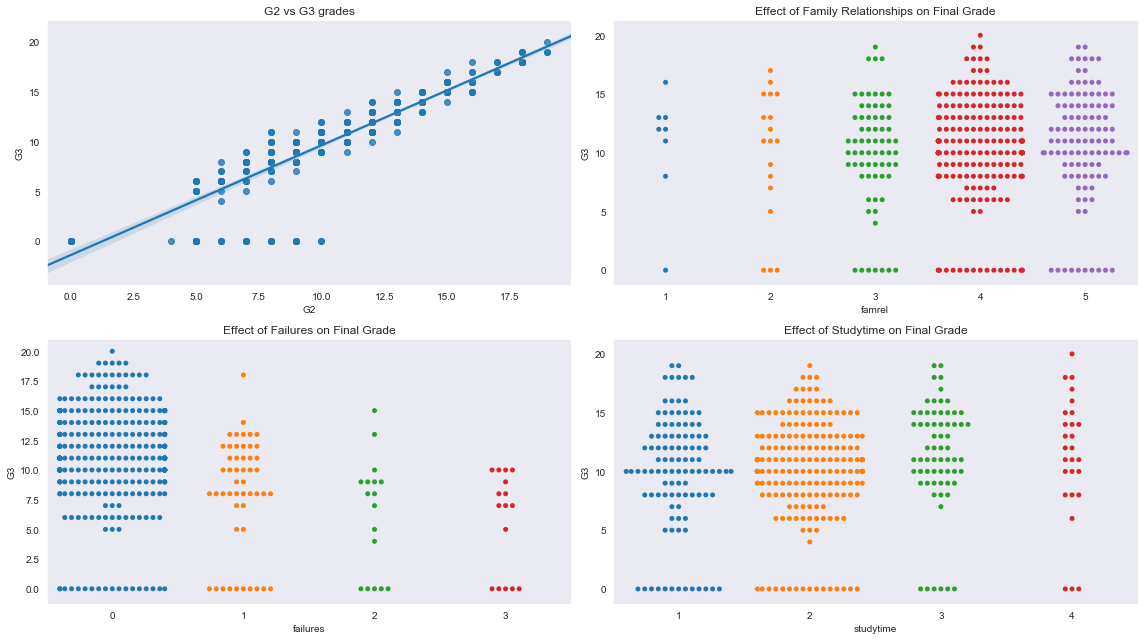

In [31]:
# Lets do some visual-EDA on our data which we will use

fig, axes = plt.subplots(2, 2, figsize=(16,9))

sns.regplot('G2', 'G3', data=maths, ax=axes[0, 0]).set_title('G2 vs G3 grades')
sns.swarmplot('failures', 'G3', data=maths, ax=axes[1, 0]).set_title('Effect of Failures on Final Grade')
sns.swarmplot('famrel', 'G3', data=maths, ax=axes[0, 1]).set_title('Effect of Family Relationships on Final Grade')
sns.swarmplot('studytime', 'G3', data=maths, ax=axes[1, 1]).set_title('Effect of Studytime on Final Grade')
plt.tight_layout()
plt.show()

We can see above that there is clearly a linear relationship between a students final grade and what grades they achieved earlier. This also seems to be a positive relationship between the strength of a family bond and a students academic preformance.

The data is in good shape. However we can see that some variables here are down as numeric when they are actually categorical. E.G. 'Medu' denotes the mothers education level from 1-4 rather than a quantity or numerical feature.

Even some of the numbers that you would naturally think should be numerical actually seem to be categorical when you inspect the description of the data, such as studytime. I will see if changing this to categorical makes my model more accurate.

In [32]:
print(maths.select_dtypes('int64').columns.values)

['age' 'Medu' 'Fedu' 'traveltime' 'studytime' 'failures' 'famrel'
 'freetime' 'goout' 'Dalc' 'Walc' 'health' 'absences' 'G1' 'G2' 'G3']


In [33]:
cols_to_change = {'Medu':'category', 'Fedu':'category', 'traveltime':'category',
                  'studytime':'category', 'famrel':'category','freetime':'category',
                  'goout':'category', 'Dalc':'category', 'Walc':'category',
                  'health':'category',}

maths = maths.astype(cols_to_change)
maths = pd.get_dummies(maths, drop_first=True)
print(maths.shape)

(395, 70)


We can see now that the dataframe has 70 predictive variables after having converted our
object and categorical columns to dummy variables.

Lets preform a lasso regression analysis to filter out the best predictive variables.
We can tune the parameters using cross-validation to find the best alpha values for our
lasso regression.

In [34]:
# Initiate the LassoCV and split the data
alphas = np.linspace(0.01, 4, 100)
lasso_cv = LassoCV(alphas=alphas, random_state=42, cv=5)
X = maths.drop('G3', axis=1)
y = np.array(maths.G3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
# Fit the data to the model
# See how well the model preforms
lasso_cv.fit(X_train, y_train)
y_pred = lasso_cv.predict(X_test)
rmse = (MSE(y_test, y_pred))**(1/2)
print('Our Optimal alpha is: ', lasso_cv.alpha_)
print('Our r-squared score is: ', lasso_cv.score(X_test, y_test))
print('Our root means-squared error is: ', rmse)

Our Optimal alpha is:  0.05030303030303031
Our r-squared score is:  0.7943067964244415
Our root means-squared error is:  2.12639625769625


Our model isn't too bad. It explains nearly 80% of the final mark that students get, and we are off on average by 2 marks. This would be greatly improved if we removed the students who didn't sit the final test and recieved 0 for G3. With some more tuning maybe we can get it more accurate.

One benefit of Lasso regression is that it shrinks coefficients that are not relevant for our model. We can use this to show us exactly what is contributing to our output variable.

In [36]:
coeff = {}

for i in range(len(X.columns.values)):
    coeff[X.columns.values[i]] = lasso_cv.coef_[i]

coeff_df = pd.DataFrame.from_dict(coeff, orient='index', columns=['Coefficients'])
coeff_df = coeff_df[coeff_df['Coefficients'] != 0].reset_index()

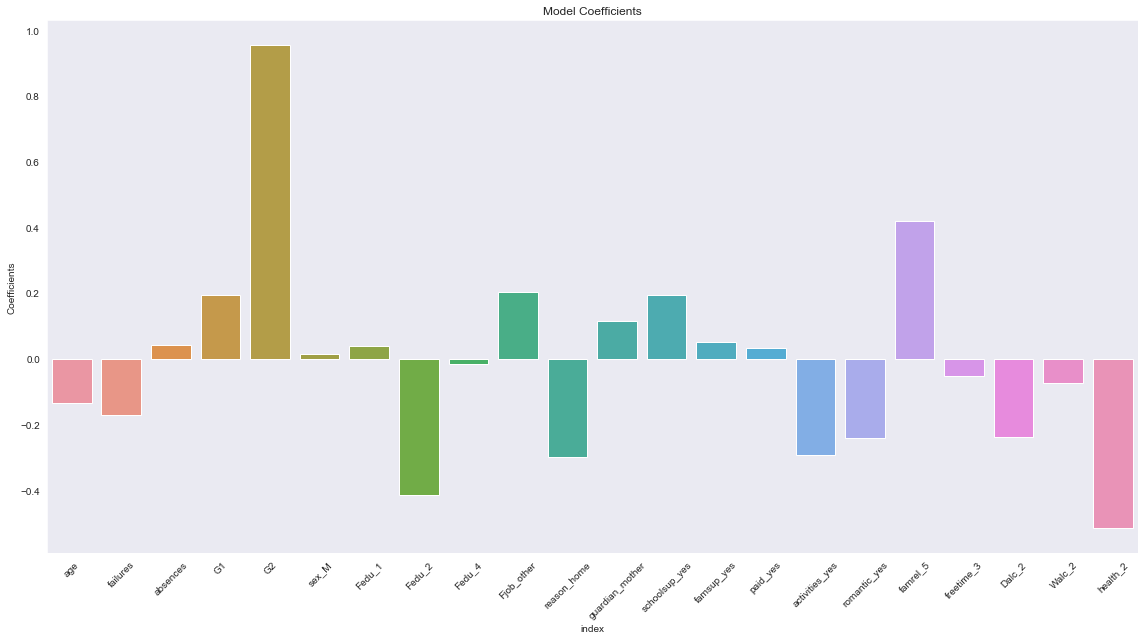

In [37]:
fig, axes = plt.subplots(figsize=(16,9))
sns.set_style('dark')
sns.barplot(x='index', y='Coefficients', data=coeff_df)
plt.xticks(rotation=45)
plt.title('Model Coefficients')
plt.tight_layout()
plt.show()

We can clearly see above what factors effect the outcome of a students score. Past test scores are a very good predictor, however there are some interesting insights. Strong family relationships are positive for a students preformance, whereas if the student is considered unhealthy (with a health score of 2 out of 5) then this has a negative impact. 

As always you need to be aware that correlation doen't imply causation. Our model predicts that the students age has a slight negative impact on a students outcome. Is this down to other factors though?!